In [21]:
#%pip install numpy
#%pip install pandas
#%pip install pickle
#%pip install ipywidgets
#%pip install matplotlib
import numpy as np
import pandas as pd
import pickle
import copy
import time
from ipywidgets import interact
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import torch
import torch.nn as nn 

#%pip install pyarrow
##%pip install fastparquet

### J'ai des pb avec lire les pickles sur mon google drive donc je laisse de téco pr l'instant


In [22]:
df0 = pd.read_parquet('pass0.parquet')
df1 = pd.read_parquet('pass1.parquet')

In [ ]:
print(list(df0))
df0.head()
df0.info()

['IRI_mean', 'IRI_sequence', 'GM.TS_or_Distance', 'GM.T', 'GM.lat_int', 'GM.lon_int', 'GM.acc.xyz.z', 'GM.acc.xyz.y', 'GM.acc.xyz.x', 'GM.obd.spd_veh.value']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2274 entries, 0 to 2273
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   IRI_mean              2274 non-null   float64
 1   IRI_sequence          2274 non-null   object 
 2   GM.TS_or_Distance     2274 non-null   object 
 3   GM.T                  2274 non-null   object 
 4   GM.lat_int            2274 non-null   object 
 5   GM.lon_int            2274 non-null   object 
 6   GM.acc.xyz.z          2274 non-null   object 
 7   GM.acc.xyz.y          2274 non-null   object 
 8   GM.acc.xyz.x          2274 non-null   object 
 9   GM.obd.spd_veh.value  2274 non-null   object 
dtypes: float64(1), object(9)
memory usage: 177.8+ KB


In [ ]:
def show(col):
    try:
        plt.hist(df0[col].map(len), bins=20)
        plt.show()
        plt.plot(df0.loc[0,col])
    except:
        ...#reeee
    
interact(show, col=list(df0))

interactive(children=(Dropdown(description='col', options=('IRI_mean', 'IRI_sequence', 'GM.TS_or_Distance', 'G…

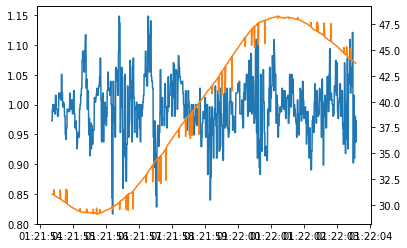

In [ ]:
s0 = df0.loc[0]
mask = s0['GM.T'] == 'acc.xyz'
accT = s0['GM.TS_or_Distance'][mask]
accZ = s0['GM.acc.xyz.z']
obdT = s0['GM.TS_or_Distance'][~mask]
obd = s0['GM.obd.spd_veh.value']

# plt.plot(accZ)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(accT, accZ, color='#1f77b4')
ax2.plot(obdT, obd, color='#ff7f0e')

# weird stuff on the orange curve (?)

In [ ]:
df_0_train = df0[:500]
df_0_val = df0[1800:]
df_0_test = df0[1497:1503]

In [ ]:
class MyDS(Dataset):
    def __init__(self, fname, size=None):
        df = fname
        zacc = df['GM.acc.xyz.z'] # Series[arr[:]float]
        
        if not size:
            size = zacc.map(len).quantile(.1)
            size = (int(size) // 32) * 32
        self.sz = size
        zacc = zacc[zacc.map(len) >= size]
        
        def truncate(arr):
            return arr[:size]
        zacc = np.stack(zacc.map(truncate)).astype('float32')
        print(zacc.shape, size)
        print(type(zacc))
        print(zacc[0].shape, size)
        self.zacc = zacc
        
    
    def __getitem__(self, idx):
        return self.zacc[idx][None,:]
    
    def __len__(self):
        return len(self.zacc)

L = 1048
train_data = MyDS(df_0_train, L) #size = N
val_data = MyDS(df_0_val, L) #size = N
test_data = MyDS(df_0_test, L) #size = N

dataloader_train = DataLoader(train_data, shuffle=True)
dataloader_val = DataLoader(val_data, shuffle=True)
dataloader_test = DataLoader(test_data, shuffle=True)


(487, 1048) 1048
<class 'numpy.ndarray'>
(1048,) 1048
(467, 1048) 1048
<class 'numpy.ndarray'>
(1048,) 1048
(6, 1048) 1048
<class 'numpy.ndarray'>
(1048,) 1048


In [ ]:
class AE(nn.Module):
    def __init__(self, hidden_units, num_features, L,latent_features=3):
        super().__init__()
        
        mid = L // (4*4*4) #latent space dims
        assert L % (4*4*4) == 0
        
        self.encoder = nn.Sequential(
            
            nn.LSTM(input_size =num_features, hidden_size =hidden_units),
            nn.ReLU(),
            # bottleneck layer
            nn.Linear(in_features=hidden_units, out_features=latent_features)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=hidden_units),
            nn.ReLU(),
            # output layer, projecting back to image size
            nn.LSTM(input_size =hidden_units, hidden_size =num_features)
        )
  
    def forward(self, x):
        encoded = self.encoder(x)
        # print(encoded.shape)
        decoded = self.decoder(encoded)
        return decoded
        
    def get_latent(self,x):
        return self.encoder(x)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim):
        super(Encoder, self).__init__()
        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )
        self.rnn2 = nn.LSTM(
          input_size=self.hidden_dim,
          hidden_size=embedding_dim,
          num_layers=1,
          batch_first=True
        )
    def forward(self, x):
        x = x.reshape((1, self.seq_len, self.n_features))
        x, (_, _) = self.rnn1(x)
        x, (hidden_n, _) = self.rnn2(x)
        return hidden_n.reshape((self.n_features, self.embedding_dim))

    def get_latent(self,x):
        return self.encoder(x)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, seq_len, input_dim, n_features):
        super(Decoder, self).__init__()
        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features = 2 * input_dim, n_features
        self.rnn1 = nn.LSTM(
          input_size=input_dim,
          hidden_size=input_dim,
          num_layers=1,
          batch_first=True
        )
        self.rnn2 = nn.LSTM(
          input_size=input_dim,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )
        self.output_layer = nn.Linear(self.hidden_dim, n_features)
    def forward(self, x):
        x = x.repeat(self.seq_len, self.n_features)
        x = x.reshape((self.n_features, self.seq_len, self.input_dim))
        x, (hidden_n, cell_n) = self.rnn1(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        x = x.reshape((self.seq_len, self.hidden_dim))
        return self.output_layer(x)

In [ ]:
class RecurrentAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim):
        super(RecurrentAutoencoder, self).__init__()
        self.encoder = Encoder(seq_len, n_features, embedding_dim)
        self.decoder = Decoder(seq_len, embedding_dim, n_features)
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    def get_latent(self,x):
        return self.encoder(x)

In [ ]:
def visualization(x,display = True):
    tsne = TSNE(n_components=2, n_iter=3000, )
    vis = tsne.fit_transform(x)
    if display:
        fig, ax = plt.subplots()
        ax.scatter(*vis.T)
        plt.show()
    else:
        return vis

In [ ]:
hidden_units = 16
num_features = 1
seq_len = L
model = RecurrentAutoencoder(seq_len, num_features,hidden_units)
model

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 32, batch_first=True)
    (rnn2): LSTM(32, 16, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(16, 16, batch_first=True)
    (rnn2): LSTM(16, 32, batch_first=True)
    (output_layer): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [ ]:
def train_model(model, train_dataset, val_dataset, n_epochs,seq_len):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss() # L1 reduction='sum'
    history = dict(train=[], val=[])
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0
    for epoch in range(1, n_epochs + 1):
        t0 = time.time()
        print(f"Epoch {epoch} loading...")
        model = model.train()
        train_losses = []
        for sequences in train_dataset:
            sequence0 = sequences[0]
            sequence0 = sequence0.reshape([seq_len,1])
            sequences = [sequence0]
            #print(sequences.shape)
            for seq_true in sequences:
                seq_true=seq_true.reshape([seq_len,1])
                #print("seq_true that goes into model",seq_true.shape)
                #print(type(seq_true))
                optimizer.zero_grad()
                seq_pred = model(seq_true)
                #print("seq_pred out of model",seq_pred.shape)
                loss = criterion(seq_pred, seq_true)

                loss.backward()
                optimizer.step()

                train_losses.append(loss.item())

        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for sequences in val_dataset:
                sequence0 = sequences[0]
                sequence0 = sequence0.reshape([seq_len,1])
                sequences = [sequence0]
                #print(sequences.shape)
                for seq_true in sequences:
                    seq_true=seq_true.reshape([seq_len,1])
                    seq_pred = model(seq_true)
                    loss = criterion(seq_pred, seq_true)
                    val_losses.append(loss.item())

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        history['train'].append(train_loss)
        history['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
        t1 = time.time()
        time_diff = t1 - t0
        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
        print("Epoch took {:.2f}s".format(time_diff))


    model.load_state_dict(best_model_wts)
    return model.eval(), history

In [ ]:
model, history = train_model(
  model, 
  dataloader_train, 
  dataloader_val, 
  n_epochs=5,
  seq_len=seq_lene
)


Epoch 1 loading...
Epoch 1: train loss 0.3940560878837745 val loss 0.054191544508397964
Epoch took 428.73s
Epoch 2 loading...
Epoch 2: train loss 0.015746586583769887 val loss 0.0024942500186222556
Epoch took 426.60s
Epoch 3 loading...
Epoch 3: train loss 0.0017285702293628762 val loss 0.001138981872019348
Epoch took 428.66s
Epoch 4 loading...
Epoch 4: train loss 0.0013849354560094458 val loss 0.0010992735691931462
Epoch took 424.73s
Epoch 5 loading...
Epoch 5: train loss 0.0013760150079395492 val loss 0.0010975807214931564
Epoch took 424.43s


In [ ]:
MODEL_PATH = 'model2.pth'

torch.save(model, MODEL_PATH)

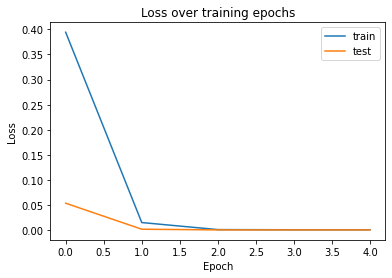

In [ ]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.savefig("Loss", dpi=150)
plt.show()

In [ ]:
def predict(model, dataset,seq_len):
    predictions, losses, real = [], [], []
    criterion = nn.MSELoss()
    with torch.no_grad():
        model = model.eval()
        for sequences in dataset:
            sequence0 = sequences[0]
            sequence0 = sequence0.reshape([seq_len,1])
            sequences = [sequence0]
            for seq_true in sequences:
                #print("seq_true1 in predict()", seq_true)
                #seq_true = seq_true.reshape([seq_len,1])
                seq_true = seq_true.reshape([seq_len,1])
                print("seq_true in predict()", seq_true.shape)
                seq_pred = model(seq_true)
                print("seq_pred flatten in predict()", seq_pred)
                loss = criterion(seq_pred, seq_true)

                predictions.append(seq_pred.numpy().flatten())
                losses.append(loss.item())
                real.append(seq_true.numpy().flatten())
    return predictions, losses, real

In [ ]:
def plot_prediction(dataset, seq_len , model, title, ax,i):
    predictions, pred_losses, real = predict(model, dataset, seq_len)
    print("len prediction array", len(predictions))
    print("real prediction array", len(real))

    print("type real", type(real[1]))
    print("type pred", type(predictions[1]))
    ax.plot(real[i], label='true')
    ax.plot(predictions[i], label='reconstructed')
    ax.set_title(f'{title} (loss: {np.around(pred_losses[i], 2)})')
    ax.legend()
    

AxesSubplot(0.125,0.125;0.227941x0.755)
seq_true in predict() torch.Size([1048, 1])
seq_pred flatten in predict() tensor([[0.7263],
        [0.8266],
        [0.8905],
        ...,
        [0.9943],
        [0.9943],
        [0.9943]])
seq_true in predict() torch.Size([1048, 1])
seq_pred flatten in predict() tensor([[0.7263],
        [0.8266],
        [0.8905],
        ...,
        [0.9943],
        [0.9943],
        [0.9943]])
seq_true in predict() torch.Size([1048, 1])
seq_pred flatten in predict() tensor([[0.7263],
        [0.8266],
        [0.8905],
        ...,
        [0.9943],
        [0.9943],
        [0.9943]])
seq_true in predict() torch.Size([1048, 1])
seq_pred flatten in predict() tensor([[0.7263],
        [0.8266],
        [0.8905],
        ...,
        [0.9943],
        [0.9943],
        [0.9943]])
seq_true in predict() torch.Size([1048, 1])
seq_pred flatten in predict() tensor([[0.7263],
        [0.8266],
        [0.8905],
        ...,
        [0.9943],
        [0.9943],

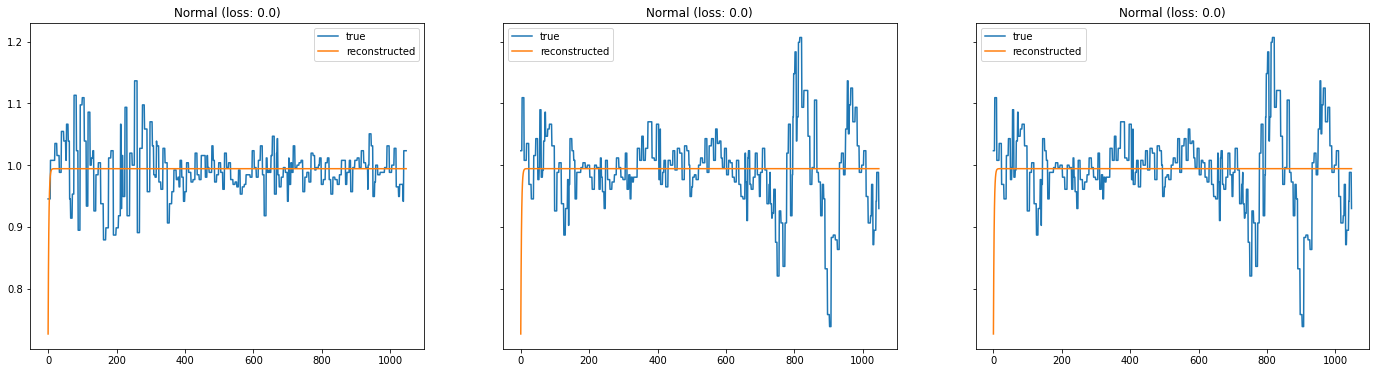

In [ ]:
fig, axs = plt.subplots(
  nrows=1,
  ncols=3,
  sharey=True,
  sharex=True,
  figsize=(24, 6)
)
for i in range(3):
    print(axs[i])
    plot_prediction(dataloader_test, seq_len , model, title='Normal',ax=axs[i],i=i)
#plt.savefig("Reconstruction1", dpi=150)
plt.show()